# Regression Example on Mocap data

In [1]:
import autoreg
import GPy
import numpy as np
from pylab import *
import tables
from IPython.display import HTML
%matplotlib inline

In [2]:
def comp_RMSE(a,b):
    return np.sqrt(np.square(a-b).mean())

In [3]:
def gen_frames(data, data_mean, data_std, skel, imgpath):
    import os
    import GPy
    a = np.zeros((62,))
    fig = figure(figsize=(8,10))
    ax = fig.add_subplot(111, projection='3d',aspect='equal')
    ax.view_init(elev=20., azim=65)
    fig.tight_layout()
    a[3:] = (data[0])*data_out_std+data_out_mean
    p = GPy.plotting.matplot_dep.visualize.skeleton_show(a, skel ,axes=ax)
    for i in xrange(data.shape[0]):
        a[3:] = (data[i])*data_out_std+data_out_mean
        p.modify(a)
        fig.savefig(os.path.join(imgpath,'%05d'%i+'.png'))

In [5]:
from GPy.util.datasets import *

def cmu_mocap_xyz(subject, train_motions, test_motions=[], sample_every=4, data_set='cmu_mocap'):
    """Load a given subject's training and test motions from the CMU motion capture data."""
    # Load in subject skeleton.
    subject_dir = os.path.join(data_path, data_set)

    # Make sure the data is downloaded.
    all_motions = train_motions + test_motions
    resource = cmu_urls_files(([subject], [all_motions]))
    data_resources[data_set] = data_resources['cmu_mocap_full'].copy()
    data_resources[data_set]['files'] = resource['files']
    data_resources[data_set]['urls'] = resource['urls']
    if resource['urls']:
        download_data(data_set)

    skel = GPy.util.mocap.acclaim_skeleton(os.path.join(subject_dir, subject + '.asf'))
    
    
    for i in range(len(skel.vertices)):
        print i, skel.vertices[i].name     

    
    # 0 root
    # 1 lhipjoint
    # 2 lfemur
    # 3 ltibia
    # 4 lfoot
    # 5 ltoes
    # 6 rhipjoint
    # 7 rfemur
    # 8 rtibia
    # 9 rfoot
    # 10 rtoes
    # 11 lowerback
    # 12 upperback
    # 13 thorax
    # 14 lowerneck
    # 15 upperneck
    # 16 head
    # 17 lclavicle
    # 18 lhumerus
    # 19 lradius
    # 20 lwrist
    # 21 lhand
    # 22 lfingers
    # 23 lthumb
    # 24 rclavicle
    # 25 rhumerus
    # 26 rradius
    # 27 rwrist
    # 28 rhand
    # 29 rfingers
    # 30 rthumb

    
    
    
    
    # Set up labels for each sequence
    exlbls = np.eye(len(train_motions))

    # Load sequences
    tot_length = 0
    temp_Y = []
    temp_Yxyz = []
    temp_lbls = []
    #u_inds = [15,16,17]
    #root_inds = [0,1,2]
    u_inds=[17]
    root_inds = [2]
    
    for i in range(len(train_motions)):
        temp_chan = skel.load_channels(os.path.join(subject_dir, subject + '_' + train_motions[i] + '.amc'))
        #temp_xyz_chan = skel.to_xyz(temp_chan.flatten()) ## A
        # Apparently the above is equiv. to giving temp_chan[0,:]. It's returning a 31 x 3 matrix.
        # I need to do this for every temp_chan[j,:], and serialize the result. The toe should be the
        # very last dimension (I think).
        #temp_xyz_chan = np.zeros((temp_chan.shape[0],93))
        #A -------
        temp_xyz_chan = np.zeros((temp_chan.shape[0],len(u_inds)))                        
        for j in range(temp_xyz_chan.shape[0]):                                 
            foo = skel.to_xyz(temp_chan[j,:]).flatten()
            temp_xyz_chan[j,:] = foo[u_inds] - foo[root_inds]
        #----A
        temp_Y.append(temp_chan[::sample_every, :])
        temp_Yxyz.append(temp_xyz_chan[::sample_every, :]) ## A
        temp_lbls.append(np.tile(exlbls[i, :], (temp_Y[i].shape[0], 1)))
        tot_length += temp_Y[i].shape[0]

    Y = np.zeros((tot_length, temp_Y[0].shape[1]))
    Yxyz = np.zeros((tot_length, temp_Yxyz[0].shape[1])) #A
    lbls = np.zeros((tot_length, temp_lbls[0].shape[1]))

    #pb.plot(temp_Yxyz[-1][:,15:18]-temp_Yxyz[-1][:,0:3],'x-')

    end_ind = 0
    for i in range(len(temp_Y)):
        start_ind = end_ind
        end_ind += temp_Y[i].shape[0]
        Y[start_ind:end_ind, :] = temp_Y[i]
        Yxyz[start_ind:end_ind, :] = temp_Yxyz[i] #A
        lbls[start_ind:end_ind, :] = temp_lbls[i]
    if len(test_motions) > 0:
        temp_Ytest = []
        temp_lblstest = []
        temp_Yxyz_test = []

        testexlbls = np.eye(len(test_motions))
        tot_test_length = 0
        for i in range(len(test_motions)):
            temp_chan = skel.load_channels(os.path.join(subject_dir, subject + '_' + test_motions[i] + '.amc'))
            #A -------
            temp_xyz_chan = np.zeros((temp_chan.shape[0],len(u_inds)))                        
            for j in range(temp_xyz_chan.shape[0]):                                 
                foo = skel.to_xyz(temp_chan[j,:]).flatten()
                temp_xyz_chan[j,:] = foo[u_inds] - foo[root_inds]
            #----A
            temp_Ytest.append(temp_chan[::sample_every, :])
            temp_Yxyz_test.append(temp_xyz_chan[::sample_every, :]) ## A
            temp_lblstest.append(np.tile(testexlbls[i, :], (temp_Ytest[i].shape[0], 1)))
            tot_test_length += temp_Ytest[i].shape[0]

        # Load test data
        Ytest = np.zeros((tot_test_length, temp_Ytest[0].shape[1]))
        Yxyz_test = np.zeros((tot_test_length, temp_Yxyz_test[0].shape[1])) #A
        lblstest = np.zeros((tot_test_length, temp_lblstest[0].shape[1]))

        end_ind = 0
        for i in range(len(temp_Ytest)):
            start_ind = end_ind
            end_ind += temp_Ytest[i].shape[0]
            Ytest[start_ind:end_ind, :] = temp_Ytest[i]
            Yxyz_test[start_ind:end_ind, :] = temp_Yxyz_test[i] #A
            lblstest[start_ind:end_ind, :] = temp_lblstest[i]
    else:
        Ytest = None
        lblstest = None

    info = 'Subject: ' + subject + '. Training motions: '
    for motion in train_motions:
        info += motion + ', '
    info = info[:-2]
    if len(test_motions) > 0:
        info += '. Test motions: '
        for motion in test_motions:
            info += motion + ', '
        info = info[:-2] + '.'
    else:
        info += '.'
    if sample_every != 1:
        info += ' Data is sub-sampled to every ' + str(sample_every) + ' frames.'
    return data_details_return({'Y': Y, 'lbls' : lbls, 'Ytest': Ytest, 'lblstest' : lblstest, 'info': info, 'skel': skel,'Yxyz':Yxyz,'Yxyz_test':Yxyz_test,'u_inds':u_inds,'root_inds':root_inds,'Yxyz_list':temp_Yxyz,'Yxyz_list_test':temp_Yxyz_test}, data_set)




## Load the dataset

In [60]:
def load_data():
    from GPy.util.datasets import cmu_mocap
    train_motions = ['01', '02', '03', '04', # walking
                '17', '18', '19', '20'] # running
    test_motions = ['05','06','07','08','21','22','23','24']
    data = cmu_mocap('35', train_motions, test_motions, sample_every=4, data_set='cmu_mocap')
    return data

def load_data_xyz():
    #train_motions = ['01', '02', '03', '04', # walking
    #            '17', '18', '19', '20'] # running
    #test_motions = ['05','06','07','08','09','10','11','12','13','14','15','16','21','22','23','24','25','26']
    train_motions = ['01', '02', '03', '04'] # walking
    test_motions = ['05','06','07','08']
    data = cmu_mocap_xyz('35', train_motions, test_motions, sample_every=4, data_set='cmu_mocap')
    return data

In [61]:
#data = load_data()
data = load_data_xyz()

0 root
1 lhipjoint
2 lfemur
3 ltibia
4 lfoot
5 ltoes
6 rhipjoint
7 rfemur
8 rtibia
9 rfoot
10 rtoes
11 lowerback
12 upperback
13 thorax
14 lowerneck
15 upperneck
16 head
17 lclavicle
18 lhumerus
19 lradius
20 lwrist
21 lhand
22 lfingers
23 lthumb
24 rclavicle
25 rhumerus
26 rradius
27 rwrist
28 rhand
29 rfingers
30 rthumb


In [62]:

y = data['Y']
u = data['Yxyz_list']
u_flat = np.vstack(u)

lbls = data['lbls']
data_out_train = y

#---- REMOVE
#datatmp = load_data()
#if np.sum(np.abs(y - datatmp['Y'])) != 0:
#    print np.sum(y - datatmp['Y'])
#----

data_out_train = data_out_train[:,3:]
data_out_mean  = data_out_train.mean(axis=0)
data_out_std   = data_out_train.std(axis=0)
data_out_train = (data_out_train-data_out_mean)/data_out_std
#data_out_train_list = [data_out_train[np.where(lbls[:,i]==1)[0]][1:] for i in range(lbls.shape[1])]
data_out_train_list = [data_out_train[np.where(lbls[:,i]==1)[0]] for i in range(lbls.shape[1])]


# Create controls
#data_in_train_list = [y[np.where(lbls[:,i]==1)[0]][:,2][1:] - y[np.where(lbls[:,i]==1)[0]][:,2][:-1] for i in range(lbls.shape[1])]
#from scipy.ndimage.filters import gaussian_filter1d
#data_in_train_list = [np.ones(d.shape+(1,))*d.mean() for d in data_in_train_list]

##data_in_train_list = [gaussian_filter1d(d,8.)[:,None] for d in data_in_train_list]
##data_in_train_list = [np.vstack([d[:10],d]) for d in data_in_train_list]


data_in_train_list = u
u_flat_mean = u_flat.mean(axis=0)
u_flat_std = u_flat.std(axis=0)
data_in_train = (u_flat-u_flat_mean)/u_flat_std
    
#data_in_train_list = u


(90, 1)
(90, 59)
90
102
107
109


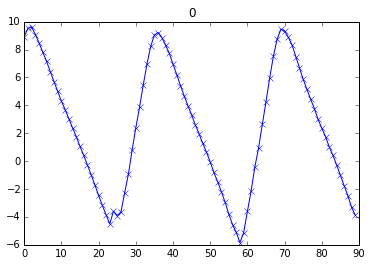

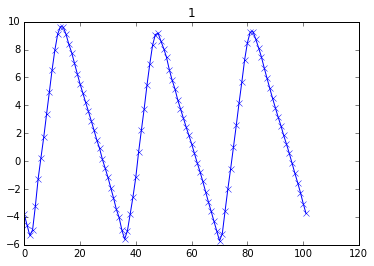

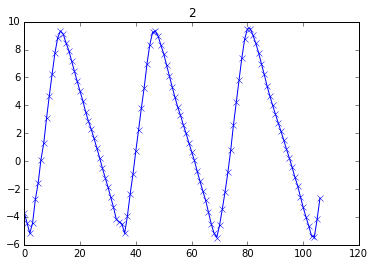

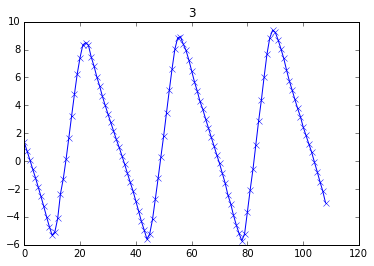

In [63]:
print data_in_train_list[0].shape
print data_out_train_list[0].shape

for i in range(len(data_in_train_list)):
    plt.figure()
    plt.plot(data_in_train_list[i], 'x-')
    plt.title(i)
    print data_in_train_list[i].shape[0]

In [64]:
print y.shape
print data_out_train.shape
print u_flat.shape
print data_in_train.shape

(408, 62)
(408, 59)
(408, 1)
(408, 1)


In [65]:
ytest = data['Ytest']
lblstest = data['lblstest']
u = data['Yxyz_list_test']
data_out_test = ytest

data_out_test= data_out_test[:,3:]
data_out_test = (data_out_test-data_out_mean)/data_out_std

#data_out_test_list = [data_out_test[np.where(lblstest[:,i]==1)[0]][1:] for i in range(lblstest.shape[1])]
data_out_test_list = [data_out_test[np.where(lblstest[:,i]==1)[0]] for i in range(lblstest.shape[1])]

# Create controls
#data_in_test_list = [ytest[np.where(lblstest[:,i]==1)[0]][:,2][1:] - ytest[np.where(lblstest[:,i]==1)[0]][:,2][:-1] for i in range(lblstest.shape[1])]
#data_in_test_list = [np.ones(d.shape+(1,))*d.mean() for d in data_in_test_list]

#data_in_test_list = u

data_in_test_list = u
data_in_test = (u_flat-u_flat_mean)/u_flat_std

## Fit a model without NN-constraint

In [28]:
# Down-scaling the input signals
#data_in_train_list = [d*0.1 for d in data_in_train_list]
#data_in_test_list = [d*0.1 for d in data_in_test_list]
#data_in_train = data_in_train*0.1

In [66]:
data_in_test_list = [(d-u_flat_mean)/u_flat_std for d in data_in_test_list]

In [67]:
#=============================
# Initialize a model
#=============================

Q = 100 # 200
win_in = 20 # 20
win_out = 20 # 20
use_controls = True
back_cstr = False



# create the model
if use_controls:
    #m = autoreg.DeepAutoreg([0, win_out], data_out_train, U=data_in_train, U_win=win_in, X_variance=0.05,
    #                    num_inducing=Q, back_cstr=back_cstr, MLP_dims=[300,200], nDims=[data_out_train.shape[1],1],
    #                     kernels=[GPy.kern.RBF(win_out,ARD=True,inv_l=True, useGPU=True),
    #                     GPy.kern.RBF(win_out+win_in,ARD=True,inv_l=True, useGPU=True)])
    m = autoreg.DeepAutoreg([0, win_out, win_out], data_out_train, U=data_in_train, U_win=win_in, X_variance=0.05,
                        num_inducing=Q, back_cstr=back_cstr, MLP_dims=[300,200], nDims=[data_out_train.shape[1],1,1],
                         kernels=[GPy.kern.RBF(win_out,ARD=True,inv_l=True, useGPU=True),
                         GPy.kern.RBF(win_out+win_out,ARD=True,inv_l=True, useGPU=True),
                         GPy.kern.RBF(win_out+win_in,ARD=True,inv_l=True, useGPU=True)])
    #m = autoreg.DeepAutoreg([0, win_out, win_out], data_out_train_list, U=data_in_train_list, U_win=win_in, X_variance=0.05,
    #                    num_inducing=Q, back_cstr=back_cstr, MLP_dims=[300,200], nDims=[data_out_train.shape[1],1,1],
    #                     kernels=[GPy.kern.RBF(win_out,ARD=True,inv_l=True, useGPU=True),
    #                     GPy.kern.RBF(win_out+win_out,ARD=True,inv_l=True, useGPU=True),
    #                     GPy.kern.RBF(win_out+win_in,ARD=True,inv_l=True, useGPU=True)])
else:
    m = autoreg.DeepAutoreg([0, win_out], data_in_train, U=None, U_win=win_in, X_variance=0.05,
                        num_inducing=Q, back_cstr=back_cstr, MLP_dims=[200,100], nDims=[data_out_train.shape[1],1],
                         kernels=[GPy.kern.RBF(win_out,ARD=True,inv_l=True, useGPU=True),
                         GPy.kern.RBF(win_out,ARD=True,inv_l=True, useGPU=True)])


In [12]:
#=============================
# Load a trained model
#=============================

import tables
with tables.openFile('./walk_run_2.h5','r') as f:
    ps = f.root.param_array[:]
    f.close()
    m.param_array[:] = ps
    m._trigger_params_changed()

ValueError: could not broadcast input array from shape (35200) into shape (7214)

In [68]:
if not back_cstr:
    pp = GPy.util.pca.PCA(data_out_train)
    pca_projection = pp.project(data_out_train, 1)
    pca_projection = (pca_projection - pca_projection.mean()) / pca_projection.std()
    m.layer_1.Xs_flat[0].mean[:] = pca_projection
    
    m.layer_2.Xs_flat[0].mean[:] = pca_projection
    
    m._trigger_params_changed()
    
    # Random permutation for Z
#     perm = np.random.permutation(range(m.layer_1.X.mean.shape[0]))
#     m.layer_1.Z[:] = m.layer_1.X.mean[perm[0:Q],:].values.copy()
    
    # K-means initialization
    from sklearn.cluster import KMeans
    km = KMeans(n_clusters=m.layer_1.Z.shape[0],n_init=1000,max_iter=100)
    km.fit(m.layer_1.X.mean.values.copy())
    m.layer_1.Z[:] = km.cluster_centers_.copy()
    
    km = KMeans(n_clusters=m.layer_0.Z.shape[0],n_init=1000,max_iter=100)
    km.fit(m.layer_0.X.mean.values.copy())
    m.layer_0.Z[:] = km.cluster_centers_.copy()
    
    km = KMeans(n_clusters=m.layer_2.Z.shape[0],n_init=1000,max_iter=100)
    km.fit(m.layer_2.X.mean.values.copy())
    m.layer_2.Z[:] = km.cluster_centers_.copy()

    m._trigger_params_changed()

In [69]:
m_init = m.copy()

In [22]:
m = m_init.copy()

In [70]:
# initialization
for i in range(m.nLayers):
    if not back_cstr:
        m.layers[i].kern.inv_l[:]  = 1./((m.layers[i].X.mean.values.max(0)-m.layers[i].X.mean.values.min(0))/np.sqrt(2.))**2
    else:
        m.layers[i].kern.inv_l[:]  = 1./9.#((m.layers[i].X.mean.values.max(0)-m.layers[i].X.mean.values.min(0))/np.sqrt(2.))
    m.layers[i].likelihood.variance[:] = 0.01*data_out_train.var()
    m.layers[i].kern.variance.fix(warning=False)
    m.layers[i].likelihood.fix(warning=False)
    
m.layer_1.kern.variance[:] = m.layer_1.Xs_flat[0].mean.var()

m.layer_2.kern.variance[:] = m.layer_2.Xs_flat[0].mean.var()

if back_cstr:
    m.layer_1.likelihood.variance[:] = 0.01
    m.layer_1.Z.fix()
else:
    m.layer_1.likelihood.variance[:] = 0.01 * m.layer_1.Xs_flat[0].mean.var()
    m.layer_2.likelihood.variance[:] = 0.01 * m.layer_2.Xs_flat[0].mean.var()
print m


Name                              : autoreg
Log-likelihood                    : -483861.841682
Number of Parameters              : 11738
Number of Optimization Parameters : 11732
Updates                           : True
Parameters:
  autoreg.                         |       Value        |  Constraint  |  Prior  |  Tied to
  layer_2.inducing inputs          |         (100, 40)  |              |         |         
  layer_2.rbf.variance             |               1.0  |    fixed     |         |         
  layer_2.rbf.inv_lengthscale      |             (40,)  |     +ve      |         |         
  layer_2.Gaussian_noise.variance  |              0.01  |    fixed     |         |         
  layer_2.qX_0.mean                |          (408, 1)  |              |         |         
  layer_2.qX_0.variance            |          (408, 1)  |     +ve      |         |         
  layer_1.inducing inputs          |         (100, 40)  |              |         |         
  layer_1.rbf.variance         

In [ ]:
# optimization
m.optimize('bfgs',messages=1,max_iters=100) # 100
#m.layer_1.Z.unfix()
for i in range(m.nLayers):
    m.layers[i].kern.variance.constrain_positive(warning=False)
#m.optimize('bfgs',messages=1,max_iters=200) # 0
for i in range(m.nLayers):
    m.layers[i].likelihood.constrain_positive(warning=False)
m.optimize('bfgs',messages=1,max_iters=10000)

In [ ]:
#m.optimize('bfgs',messages=1,max_iters=10000)

In [41]:
print m


Name                              : autoreg
Log-likelihood                    : -24331.6663457
Number of Parameters              : 22166
Number of Optimization Parameters : 22166
Updates                           : True
Parameters:
  autoreg.                         |       Value       |  Constraint  |  Prior  |  Tied to
  layer_2.inducing inputs          |        (200, 40)  |              |         |         
  layer_2.rbf.variance             |   0.323652627861  |     +ve      |         |         
  layer_2.rbf.inv_lengthscale      |            (40,)  |     +ve      |         |         
  layer_2.Gaussian_noise.variance  |  0.0422040389863  |     +ve      |         |         
  layer_2.qX_0.mean                |         (515, 1)  |              |         |         
  layer_2.qX_0.variance            |         (515, 1)  |     +ve      |         |         
  layer_1.inducing inputs          |        (200, 40)  |              |         |         
  layer_1.rbf.variance             |   

In [67]:
# Save the model parameters
m.save('walk_run_2_new.h5')

## Evaluate the model

In [22]:
# Free-run on the training data
pds = [m.freerun(U=data_in, m_match=False) for data_in in data_in_train_list]

rmse = [comp_RMSE(pd[win_out:],gt[win_out+win_in:]) for pd, gt in zip(pds, data_out_train_list)]
rmse_all = comp_RMSE(np.vstack([pd[win_out:] for pd in pds]),np.vstack([gt[win_out+win_in:] for gt in data_out_train_list]))
print rmse
print "the overall RMSE: "+str(rmse_all)

[0.87650805402185072, 1.3889246038834675, 1.3682124514250922, 1.5525337231122056]
the overall RMSE: 1.3466767596


In [43]:
# Free-run on the test data
pds = [m.freerun(U=data_in, m_match=True).mean for data_in in data_in_test_list]

# Unnormalize data and predictions
#pds = [ p*data_out_std + data_out_mean for p in pds]
#data_out_test_list_original = [ p*data_out_std + data_out_mean for p in data_in_test_list]
#rmse = [comp_RMSE(pd[win_out:],gt[win_out+win_in:]) for pd, gt in zip(pds, data_out_test_list_original)]
#rmse_all = comp_RMSE(np.vstack([pd[win_out:] for pd in pds]),np.vstack([gt[win_out+win_in:] for gt in data_out_test_list_original]))

rmse = [comp_RMSE(pd[win_out:],gt[win_out+win_in:]) for pd, gt in zip(pds, data_out_test_list)]
rmse_all = comp_RMSE(np.vstack([pd[win_out:] for pd in pds]),np.vstack([gt[win_out+win_in:] for gt in data_out_test_list]))

print rmse
print "the overall RMSE: "+str(rmse_all)
# 0.53, total 0.55, 1 layer
# 0.50, total 0.54, 2 layers
# 0.48, total 0.50, 2 layers 200 inducing points
# 0.48, total 0.49, 2 layers 200 inducing points

[0.95947926567106379, 0.97715090640583935, 1.0705221472227391, 1.0529084952134016, 0.98809433162482785, 0.93842959684918137, 1.1072936373629181, 1.0027549908573437, 0.93964479985071458, 0.98954789603991444, 0.93322886609883349]
the overall RMSE: 0.997730273853


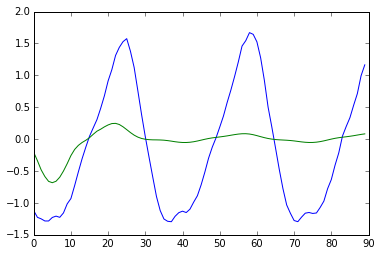

In [44]:
numTest = 0
numOutput = 3
plot(data_out_test_list[numTest][win_out:,numOutput])
plot(pds[numTest][:,numOutput])

In [ ]:
data_out_test_list_original

In [126]:
data_in_test_list[0].mean()

0.17593833502916759

## Others

In [146]:
m.layer_1.Y.mean.var()

4.529633915824939

In [145]:
m.layer_1.kern.lengthscale

AttributeError: 'MLP' object has no attribute 'lengthscale'

In [147]:
m.layer_1.X.mean.values.std(0)

array([ 1.49720692,  1.59379293,  1.66281774,  1.71489136,  1.74561589,
        1.77174932,  1.79758446,  1.81663704,  1.83379365,  1.85612847,
        1.88681233,  1.91981592,  1.95266578,  1.98463746,  2.0051089 ,
        2.02737174,  2.04854749,  2.08379001,  2.11121498,  2.12778411,
        0.5053552 ,  0.50905189,  0.51167665,  0.51271615,  0.51302051,
        0.51293417,  0.5122048 ,  0.51108828,  0.51025977,  0.50996301,
        0.50970293,  0.5086646 ,  0.50654639,  0.50368615,  0.50054116,
        0.49744697,  0.49462877,  0.49213959,  0.49023948,  0.48934644])

In [148]:
m.layer_1.X_var_0

Index,autoreg.layer_1.X_var_0,Constraint,Prior,Tied to
[0 0],0.0434249852735,+ve,,N/A
[1 0],0.0429338816992,+ve,,N/A
[2 0],0.0424016937495,+ve,,N/A
[3 0],0.0413843110302,+ve,,N/A
[4 0],0.0399299924506,+ve,,N/A
[5 0],0.0385506206554,+ve,,N/A
[6 0],0.0381347815653,+ve,,N/A
[7 0],0.0386631746286,+ve,,N/A
[8 0],0.0397105630138,+ve,,N/A
[9 0],0.0410554285005,+ve,,N/A


In [ ]:
print m.layer_0.Y.var()

print m

In [31]:
#m.save('walk_run_cesar_2layers.h5')
m.save('walk_run_cesar_2layers_200ind_2.h5')

In [ ]:
# for i in range(m.nLayers):
#     m.layers[i].likelihood.constrain_positive(warning=False)
m.optimize('bfgs',messages=1,max_iters=100000)
print m

In [122]:
#b = data_in_train.copy()
#b[:] = data_in_train.mean()
#pd = m.freerun(U=b, m_match=False)

# Test on training data
ts_inp = data_in_train_list[0].copy()   # data_in_test_list[0]
ts_out = data_out_train_list[0].copy()  # data_out_test_list[0]

pd = m.freerun(U=ts_inp*0.1, m_match=False)
# pd = m.freerun(init_Xs=[None,m.layer_1.init_Xs_0.copy()],U=ts_inp*0.1, m_match=False)

#pd = pd.mean.values*data_out_std+data_out_mean
#mean_pred = m.layer_0.Y.mean(0)*data_out_std+data_out_mean

(90, 59)

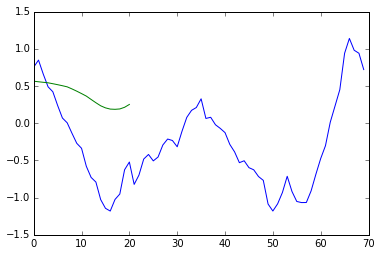

In [64]:
plot(data_out_train_list[0][win_out:,1])
plot(pd[:,1])

In [23]:
pd.shape, data_out_train_list[0].shape

((21, 59), (90, 59))

In [124]:
len(data_in_test_list)

2

In [152]:
ts_inp = data_in_test_list[0]
ts_out = data_out_test_list[0]

pd = m.freerun(U=ts_inp*0.1, m_match=False)

#pd = pd*data_out_std+data_out_mean

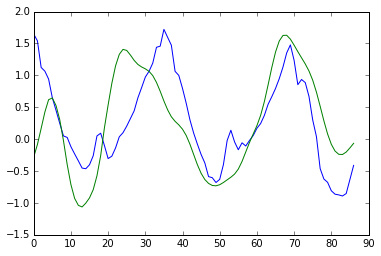

In [153]:
plot(data_out_test_list[0][20:,38])
plot(pd[:,38])

In [113]:
data_in_test_list[0].shape

(107, 1)

In [65]:
mean_pred

(87, 59)

In [38]:
print pd[0,:]
print pd[0,:]*data_out_std+data_out_mean
print ts_out[0,:]
mean_pred.shape

[-0.26375277 -0.18219682  0.18444068 -0.00566178 -0.21970811 -0.26193169
  0.07698701 -0.08504683 -0.13497963  0.23134062 -0.05228815 -0.67132009
 -0.19705366  0.27907558 -0.06351447  0.01825189  0.11549222 -0.1187323
  0.07900929 -0.06279296  0.50290286  0.05097909 -0.24627518  0.29240015
  0.04899571 -0.06212851  0.24517031  0.16481581 -1.69557841 -0.37686363
  0.26988015  0.23097896 -0.53385579  0.24638912  0.69451732 -0.15710356
  0.4385375   0.02132559 -0.19365991  0.07228145 -0.0467933  -0.21265332
 -1.6062598  -0.62611447  1.00593693 -1.60630334 -0.62036237 -0.15710356
  0.4385375   0.16494164  0.07410948 -0.14449016  0.00479086  0.07936281
  0.12459751  0.47680249  1.00593693  0.12552693 -0.41373765]
[ -1.51750788e+00  -2.04806545e+00  -1.34638185e+00  -1.13331947e+01
  -1.70720283e+00  -2.22897807e+01   4.08478363e+01  -5.00243969e+00
  -6.62498498e+00  -3.46776261e+00  -1.56301115e+01   1.38683165e+00
   2.53076578e+01   5.03082133e+01  -5.42698781e+00  -6.13339633e+00
   3.9

(59,)

In [ ]:
for i in range(pd.shape[0]):
    pd[i,:] = pd[i,:]*data_out_std+data_out_mean

In [39]:
#for i in range(1):
#    plt.figure()
#    plt.plot(ts_out[:,i])
#    plt.figure()
#    plt.plot(pd[:,i])

print pd[0:50:3,28]
print mean_pred[28]

[-1.69557841 -1.69558306 -1.69523324 -1.69364184 -1.68627577 -1.66418654
 -1.62995566 -1.68368784 -1.71585699 -1.7663893  -1.7733558  -1.69202152
 -1.69553019 -1.69559144 -1.69594445 -1.69302896 -1.68888338]
-2.06725923373


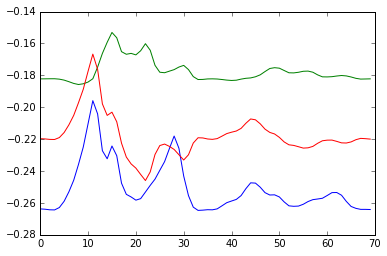

In [40]:
_=plot(pd[:,0])
_=plot(pd[:,1])
_=plot(pd[:,4])
#_=plot(data_out_train[win_out:100,0],'r')
#_=plot(data_out_train[win_out:100,1],'y')

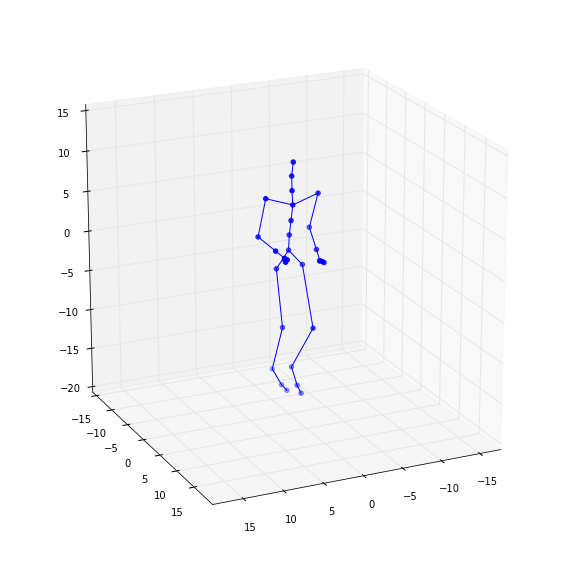

In [181]:
!rm imgs/*.png
gen_frames(pds[0][win_out:],data_out_mean, data_out_std, data['skel'],'./imgs')

In [182]:
! avconv -y -r 10 -qscale 2 -i ./imgs/%05d.png pred_walk_run_cesar5.mp4

avconv version 9.18-6:9.18-0ubuntu0.14.04.1, Copyright (c) 2000-2014 the Libav developers
  built on Mar 16 2015 13:19:10 with gcc 4.8 (Ubuntu 4.8.2-19ubuntu1)
Input #0, image2, from './imgs/%05d.png':
  Duration: 00:00:00.04, start: 0.000000, bitrate: N/A
    Stream #0.0: Video: png, bgra, 576x720, 25 tbn
[libx264 @ 0xe2c280] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX
[libx264 @ 0xe2c280] profile High, level 2.2
[libx264 @ 0xe2c280] 264 - core 142 r2389 956c8d8 - H.264/MPEG-4 AVC codec - Copyleft 2003-2014 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=12 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=10 scenecut=40 intr

In [183]:
HTML("""
<video width="480" height="480" controls>
  <source src="pred_walk_run_cesar5.mp4" type="video/mp4">
</video>
""")

In [ ]:
m.layer_1.X.mean.values

In [ ]:
m.layer_1.Us_flat[0].variance

In [ ]:
m.layer_1.kern.lengthscale

In [ ]:
m.layer_0.kern.lengthscale

In [ ]:
m.layer_1.X.mean.std(0)

In [ ]:
plot(data_in_train_list[0])
plot(data_in_train_list[6])

In [ ]:
pd = m.freerun(U=np.vstack([data_in_train_list[0],data_in_train_list[5],data_in_train_list[6],data_in_train_list[7]]),m_match=False)

In [ ]:
#=============================
# Model with NN-constraint
#=============================
Q = 500
win_in = 20
win_out = 20

use_controls = True
back_cstr = True

m = autoreg.DeepAutoreg([0, win_out], data_out_train_list, U=[d*0.1 for d in data_in_train_list], U_win=win_in, X_variance=0.05,
                    num_inducing=Q, back_cstr=back_cstr, MLP_dims=[500,200], nDims=[data_out_train.shape[1],1],
                     kernels=[GPy.kern.MLP(win_out,bias_variance=10.),
                     GPy.kern.MLP(win_out+win_in,bias_variance=10.)])
#                      kernels=[GPy.kern.RBF(win_out,ARD=True,inv_l=True, useGPU=True),
#                      GPy.kern.RBF(win_out+win_in,ARD=True,inv_l=True, useGPU=True)])